# Discrete Population Compartmental Model

Treats the population as discrete rather than continuous.

In [1]:
# Import those libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import genfromtxt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import time
from operator import add
from scipy.stats import binom
from numpy import random
from joblib import Parallel, delayed
import collections
import csv

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [3]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]
# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

In [4]:
# Create a network from a weekly dataset
my_data = genfromtxt('/Volumes/HardDrive/New_Workflow/stochastic_53/Town_Flow_20200322_20200328.csv',delimiter = ',')
A = nx.from_numpy_matrix(my_data)
A = nx.DiGraph(A)

# Use this network to label all the nodes, matching their index to the town name
towns = list(waloc['City / Town'])
labeldict = {}
for node in list(A.nodes()):
    labeldict[node] = towns[node]

In [5]:
# Read in all weekly adjacnecy matrices, assigning each entry to a dictionary.
st = os.listdir("/Volumes/HardDrive/New_Workflow/stochastic_53")

stoch = []
for i in st:
    if '._' not in i:
        stoch.append(i)
        
d = {}
for i in range(len(stoch)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/stochastic_53/"+stoch[i], header = None, sep =',')

In [7]:
# Create a df which is the average of all the flows, set it as key 100 in the dictionary 
# (so it's only referred to by choice)
df = d['0'].copy()
for i in range(1,len(stoch)):
    df += d[str(i)]
df = df/len(stoch)
d['100'] = df

In [6]:
def sveir(params,x,popn,changes,effic):
    xdot = list(np.zeros(7))
    eff1, eff2, eff3 = effic[0], effic[1], effic[2]
    xdot[0] = 1/84*x[6]- params[0]*x[0]*x[5]/popn - changes[0] # Susceptible
    xdot[1] = -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1] #One Dose
    xdot[2] = -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2] # Two doses
    xdot[3] = -eff3*params[0]*x[3]*x[5]/popn + changes[2]
    xdot[4] = params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn + eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4] #Exposed
    xdot[5] = params[1]*x[4] - params[2]*x[5] # Infected
    xdot[6] = params[2]*x[5] - 1/84*x[6] # Removed
    
    return xdot

In [123]:
def bernoulli(flow,p1,p2,p3,p4,p5,p6,p7):
    if flow == 0:
        return [0,0,0,0,0,0,0]
    else:
        vector = []
        for i in range(flow):
            r1 = random.rand()
            if r1 <= p1:
                vector.append(0)
            elif (r1>p1) & (r1 <= (p1+p2)):
                vector.append(1)
            elif (r1 > p1+p2) & (r1 <= p1+p2+p3):
                vector.append(2)
            elif (r1 > p1+p2+p3) & (r1 <= p1+p2+p3+p4):
                vector.append(3)
            elif (r1 > p1+p2+p3+p4) & (r1 <= p1+p2+p3+p4+p5):
                vector.append(4)
            elif (r1 > p1+p2+p3+p4+p5) & (r1 <= p1+p2+p3+p4+p5+p6):
                vector.append(5)
            elif (r1 > p1+p2+p3+p4+p5+p6):
                vector.append(6)
                
        occ = dict(collections.Counter(vector))
        for i in range(7):
            occ[i] = occ.get(i,0)
    
        return occ

In [124]:
def dynamics(x_init, num, steps, params, popn, changes):
    
    x = x_init
    y = []
    changes = [0,0,0]
    
    for i in range(num):
        
        xy = []
        
        for t in range(steps):
            if t == 0:
                xdot = sveir(params, x[i],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[x[i],xdot])])
            else:
                xdot = sveir(params, xy[-1],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[xy[-1],xdot])])
            #print(xy)

        y.append([int(j) for j in xy[-1]])
    
    return y

In [125]:
def movement(x_init, day, num_towns,popn):
        
    week = int(day//7)+70

    flow = d[str(week)].copy()*C
    
    move = []
    for i in range(num_towns):
        temp_mo = []
        for j in range(num_towns):
            pop = popn[i]
            mo = bernoulli(int(flow[i][j]),x_init[i][0]/pop,x_init[i][1]/pop,x_init[i][2]/pop,x_init[i][3]/pop,
                             x_init[i][4]/pop, x_init[i][5]/pop, x_init[i][6]/pop)
            temp_mo.append(mo)
        
        move.append(temp_mo)
        
    out = []   
    inc = []
    for i in range(num_towns):
        temp_out = []
        temp_inc = []
        for k in range(7):
            mini_out = []
            mini_inc = []
            for j in range(num_towns):
                mini_out.append(move[i][j][k])
                mini_inc.append(move[j][i][k])
            temp_out.append(sum(mini_out))
            temp_inc.append(sum(mini_inc))
        out.append(temp_out)
        inc.append(temp_inc)            

    return inc, out

In [138]:
# Number of towns we'll be investigating in this run (max = 53 for bigs only, 58 with sattelite towns,
# 297 for all towns)
num = 53
#Go with similar proportions as Adeliade for now
infect = 4.75*10**(-6)
x_init = [0.02,0.02,0.85,0.11-(5*infect),4*infect,infect,0]
#x_init = [1770000-(1380635+32+8),1380635-1264948,1264948-38710,38710,32,8,0]
#for i in range(len(x_init)):
#    x_init[i] = x_init[i]/1770000

# Go with 0 infections elsewhere
y_init = [0.02,0.02,0.35,0.61,0,0,0]
init = [x_init]
for i in range(num-1):
    init.append(y_init)

## Multiply it by population in each town.
popn = list(waloc['Population'])
#popn[0] = 1770000

town_init = []
for i in range(num):
    item = init[i]
    new_item = []
    for j in range(len(item)):
        new_item.append(item[j] * popn [i])
    town_init.append(new_item)  
    
    
days = 105
steps = 10

#a1, a2,a3, L, D =4.26855088, 4.50297884, 6.        , 0.5       , 0.80237211
a1, a2,a3, L, D =0.6087795 , 0.18593849, 0.55574211, 2.        , 5.
effic = [1-0.293, 1-0.128, 1-0.58]

C= 9*10**9
changes = [0,0,0]

In [139]:
params = [a1, 1/L, 1/D]

model = [town_init]

x_init = town_init

for day in range(days):

    if day < 40:
        params[0] = a1
    elif (day>= 40) and (day < 80):
        params[0] = a2
    elif day >=80:
        params[0] = a3
        
    dyn = dynamics(model[-1], num, steps, params, popn, changes)
    
    if day%7 == 0:
        inc, out = movement(model[-1], day, num, popn)

        dynmov = []
        for i in range(num):
             dynmov.append([dyn[i][d] + inc[i][d] - out[i][d] for d in range(7)])

        model.append(dynmov)
    else:
        model.append(dyn)

In [140]:
# print when infection breaks in to each town
breaks = dict()
for i in range(num):
    for day in range(days):
        if model[day][i][5] > 0:
            breaks[towns[i]] = breaks.get(towns[i], day//7)

{k: v for k, v in sorted(breaks.items(), key=lambda item: item[1])}

{'Perth': 0,
 'Mandurah': 0,
 'Newman': 3,
 'Bunbury': 7,
 'Geraldton': 7,
 'Kalgoorlie-Boulder': 7,
 'Karratha': 7,
 'Broome': 7,
 'Port Hedland': 7,
 'Northam': 7,
 'Pinjarra': 7,
 'Tom Price': 7,
 'York': 7,
 'Exmouth': 7,
 'Kambalda West': 7,
 'Wickham': 7,
 'Halls Creek': 7,
 'Paraburdoo': 7,
 'Dampier': 7,
 'Harvey': 10,
 'Merredin': 10,
 'Busselton': 14,
 'Collie': 14,
 'Dunsborough': 14,
 'Narrogin': 14,
 'Port Denison-Dongara': 14,
 'Donnybrook': 14,
 'Waroona': 14,
 'Drummond Cove': 14,
 'Capel': 14,
 'Moora': 14,
 'Kojonup': 14}

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


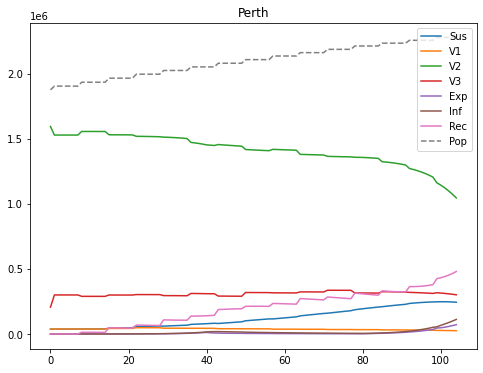

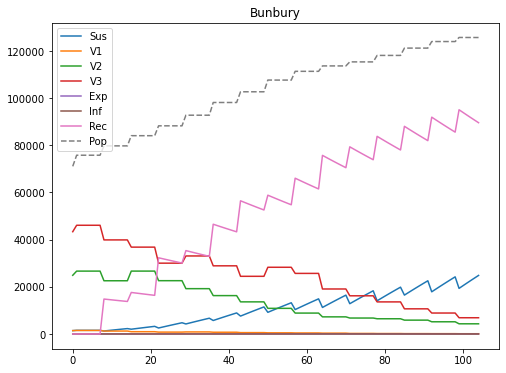

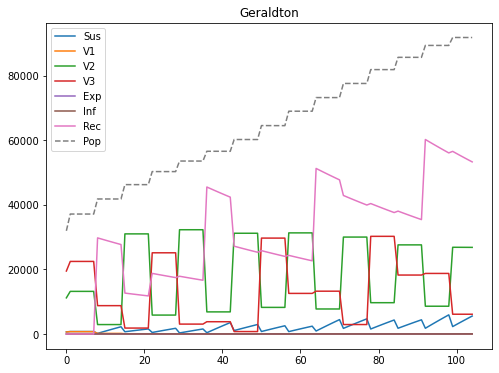

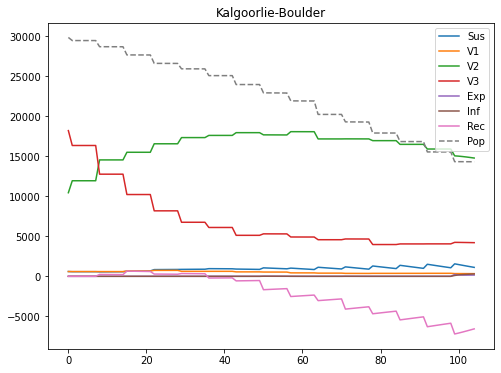

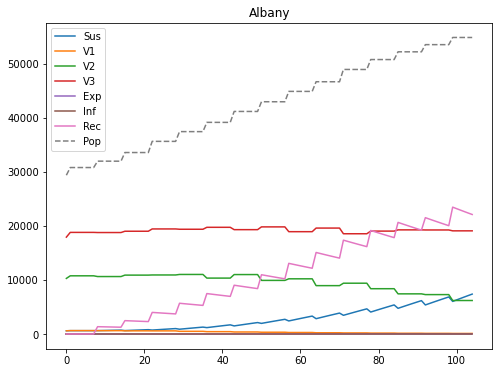

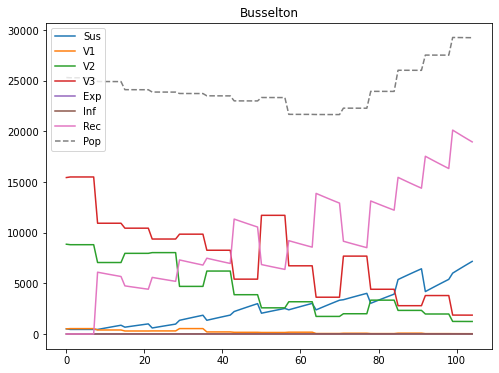

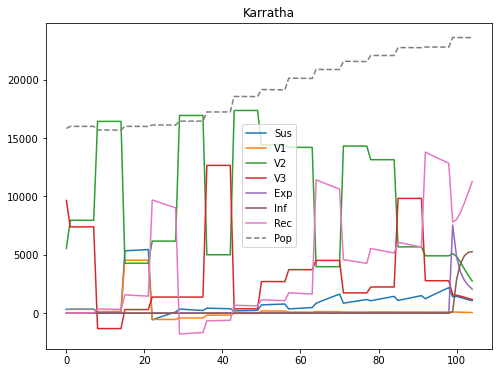

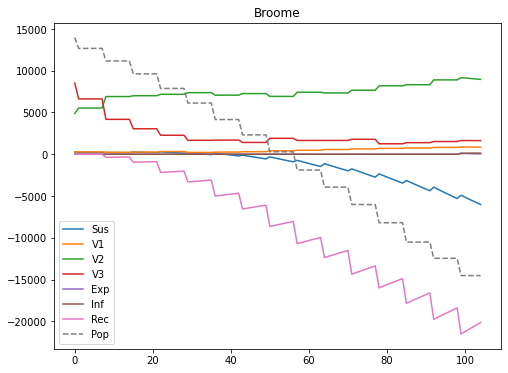

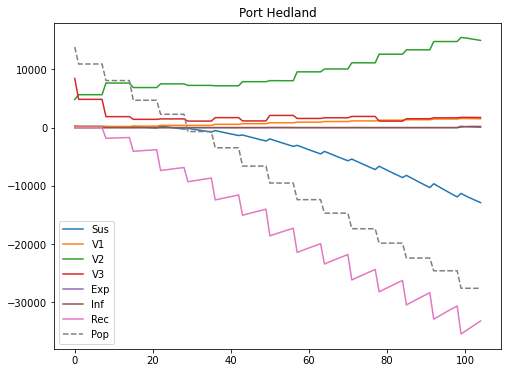

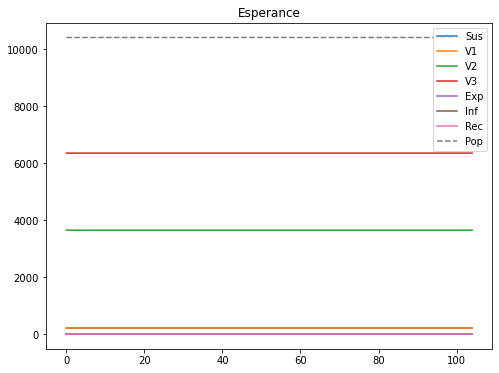

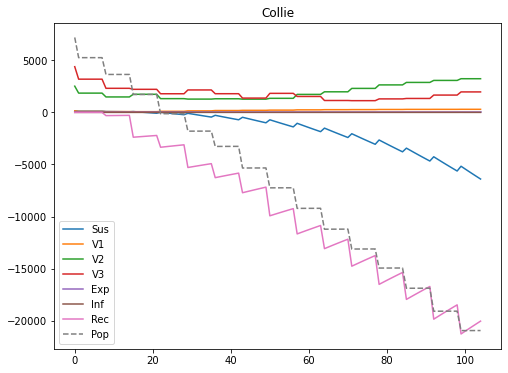

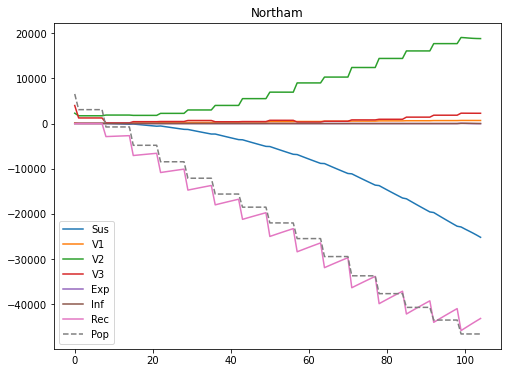

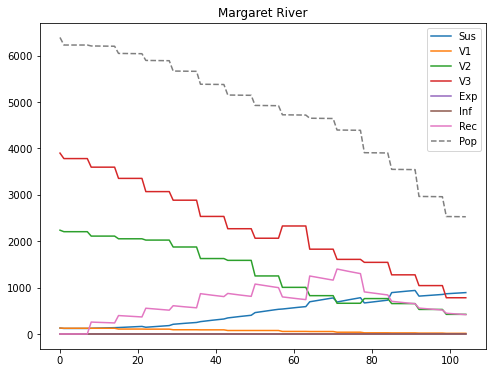

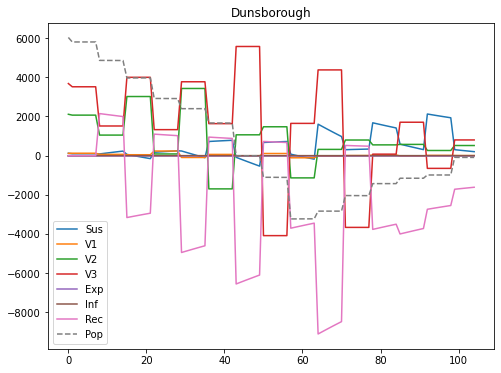

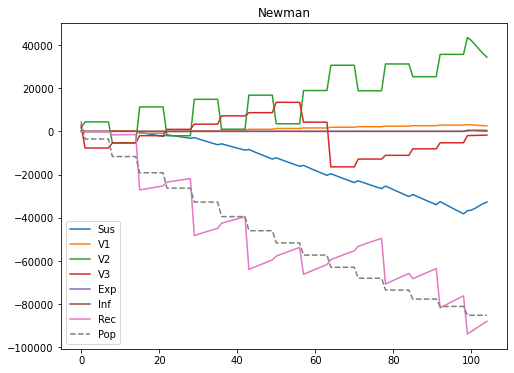

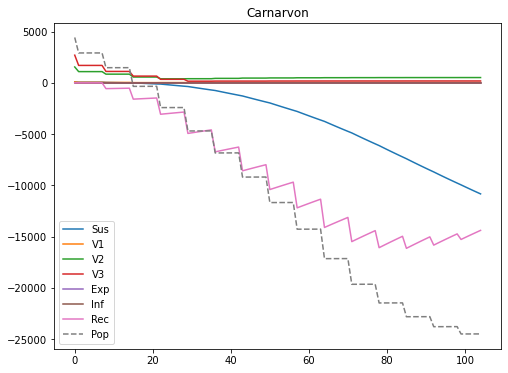

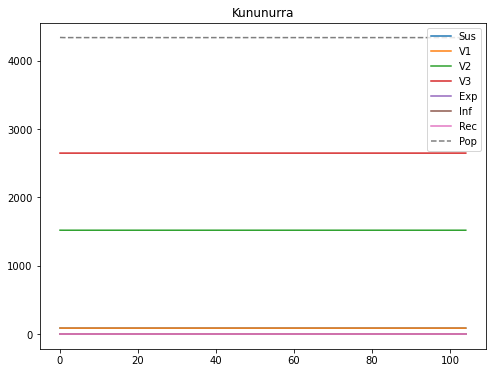

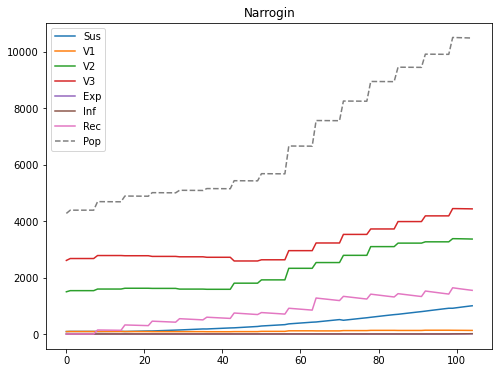

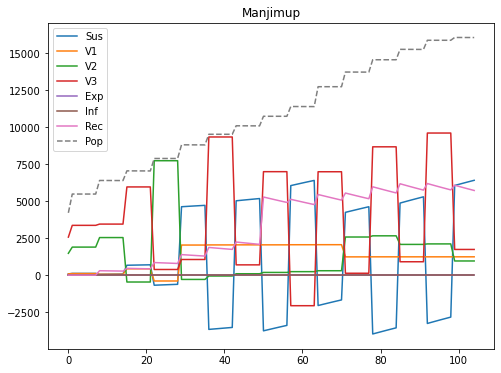

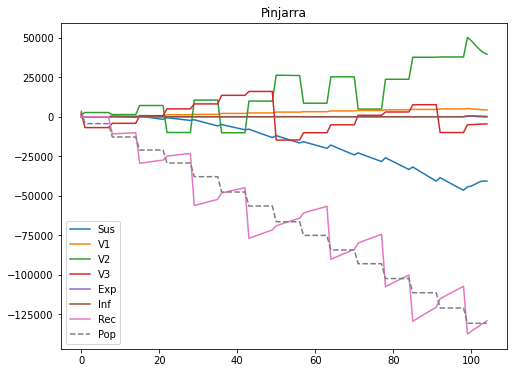

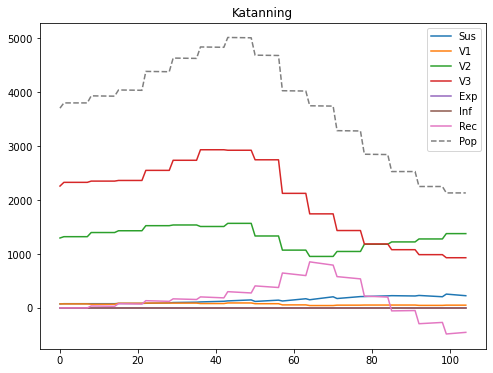

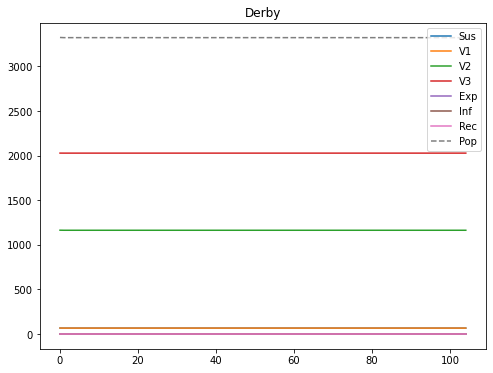

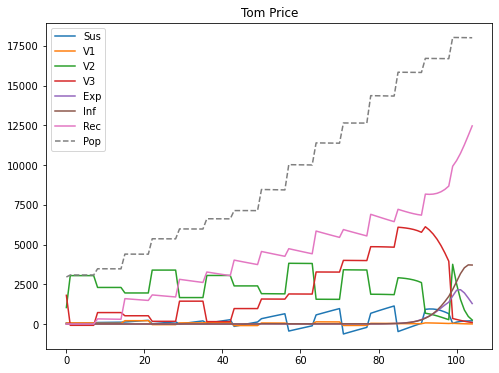

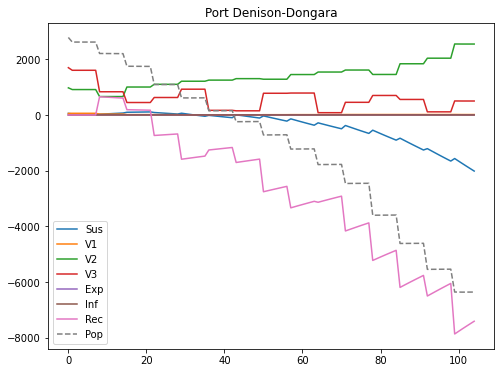

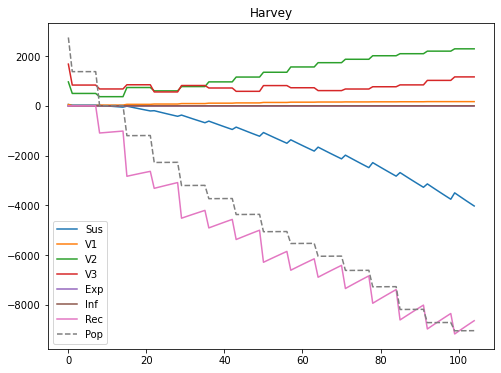

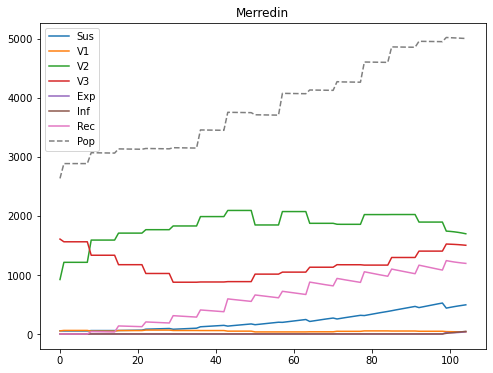

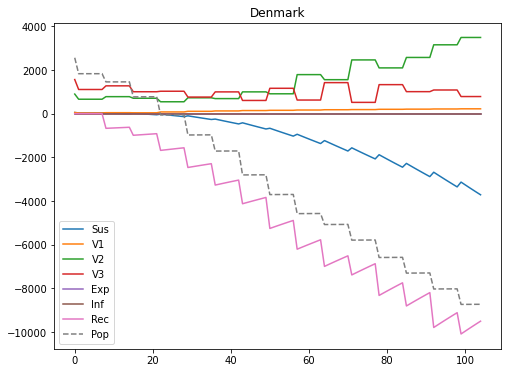

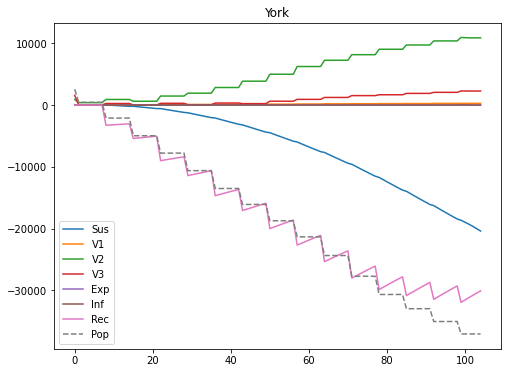

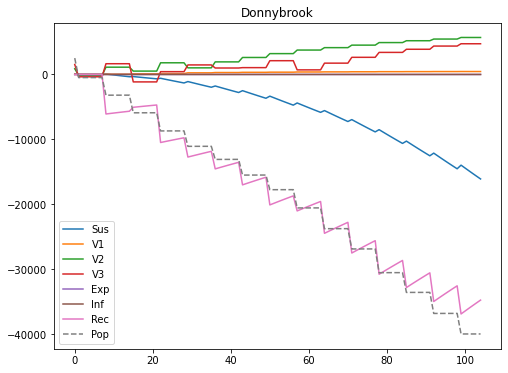

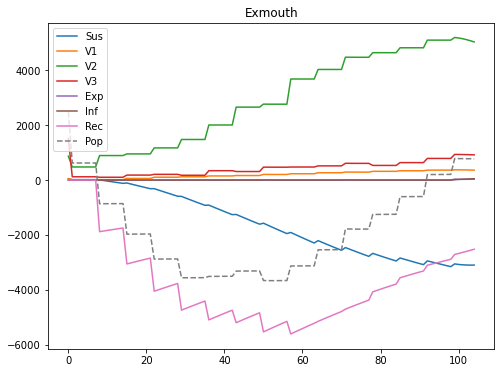

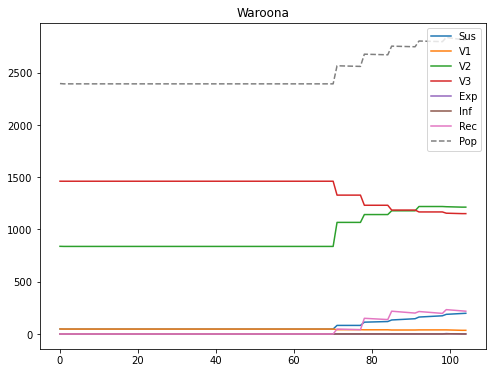

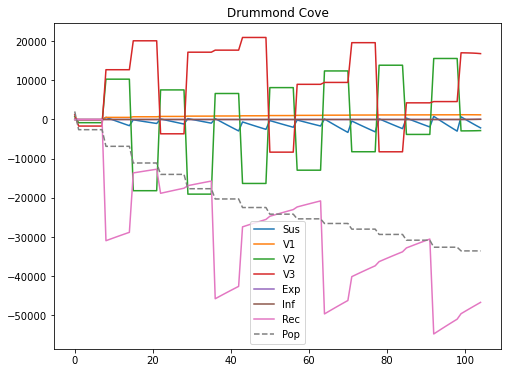

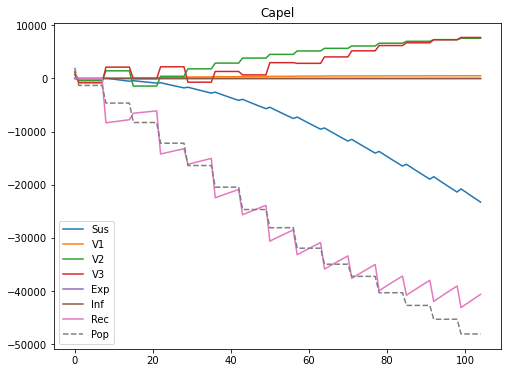

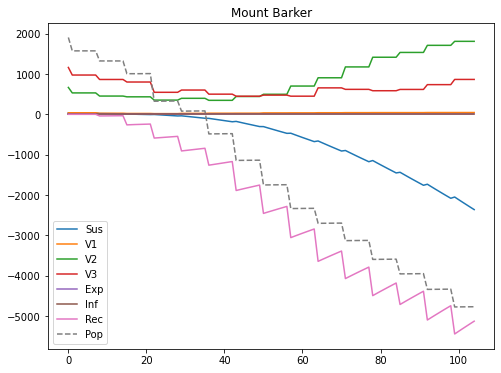

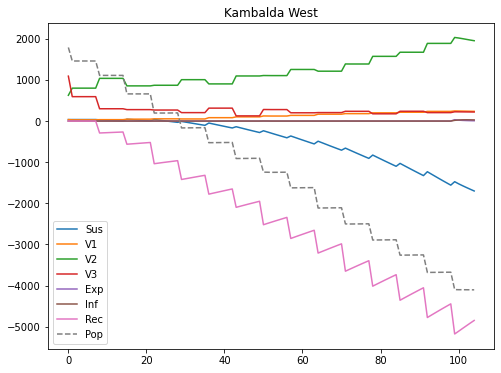

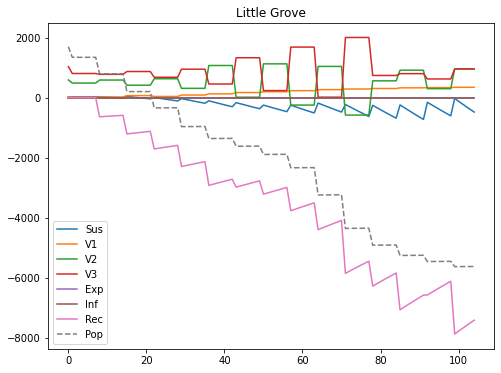

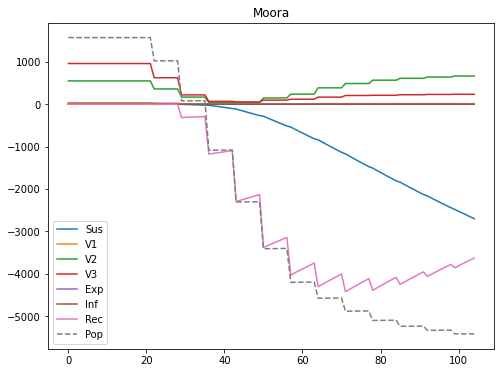

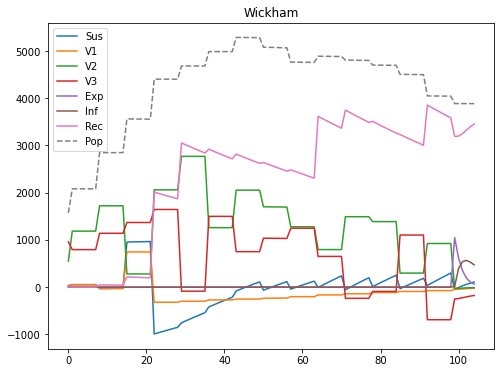

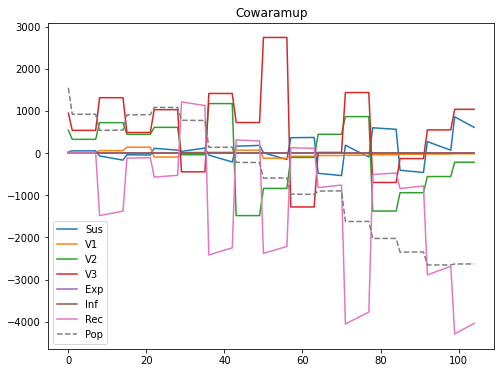

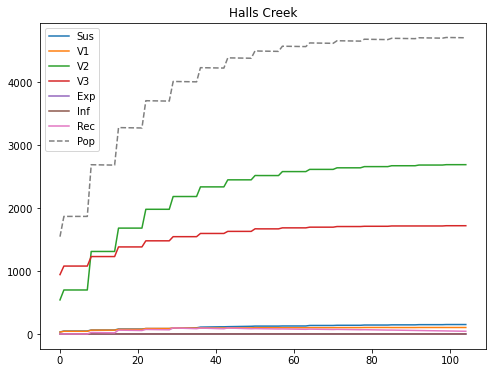

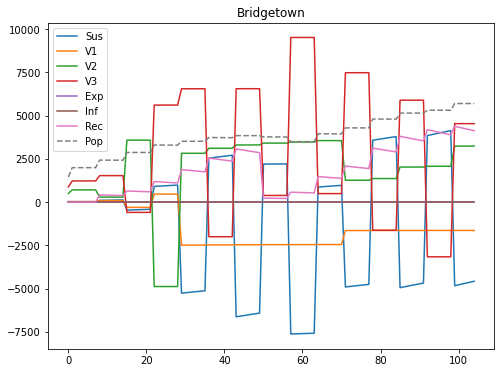

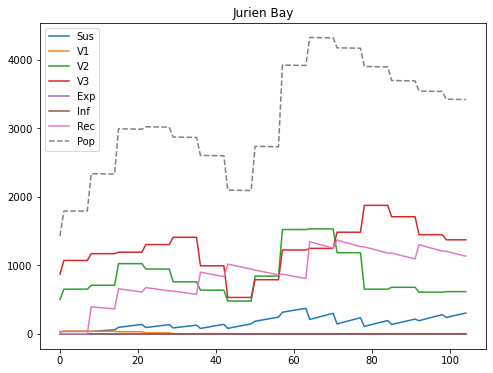

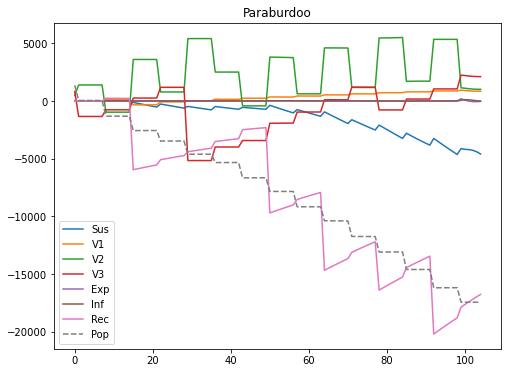

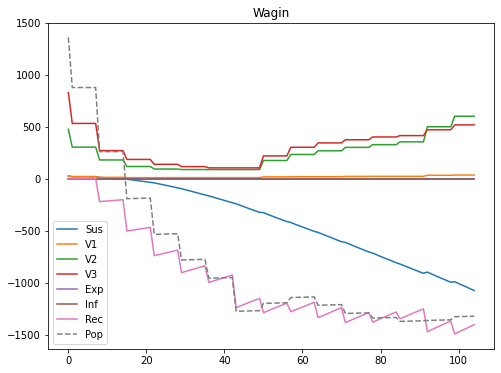

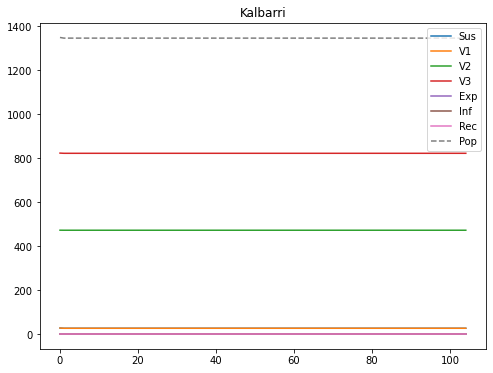

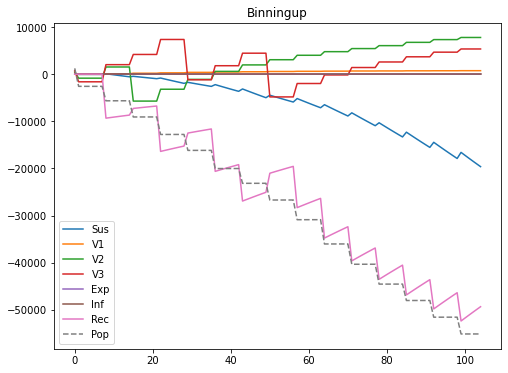

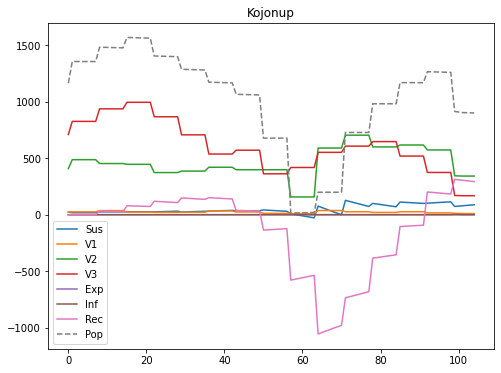

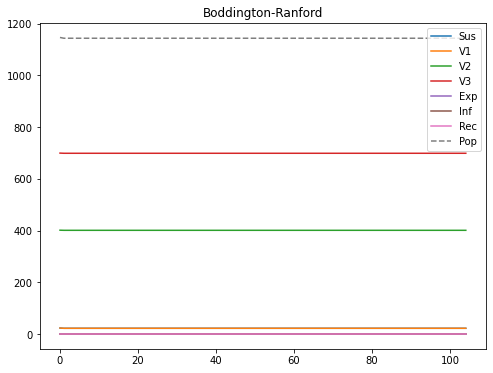

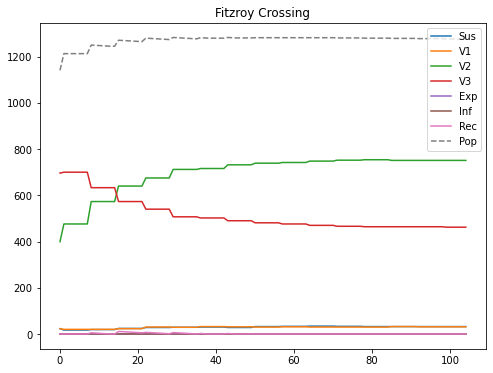

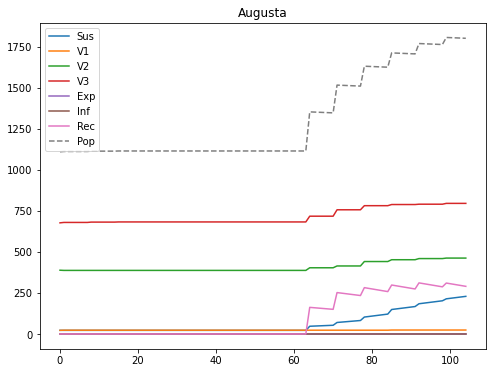

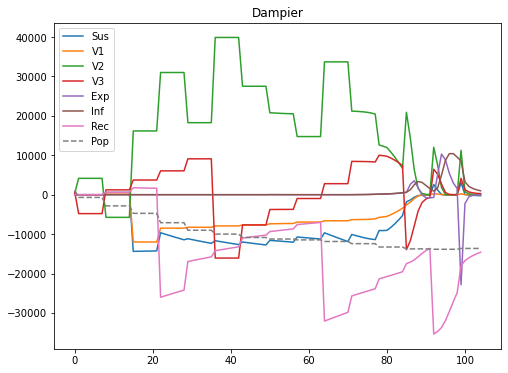

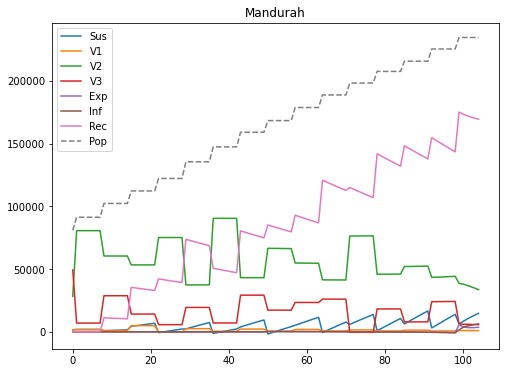

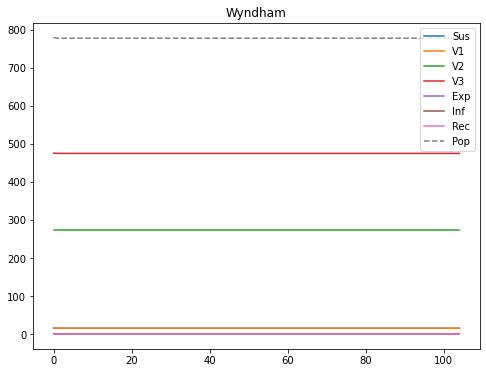

In [141]:
compartments = ['Sus', 'V1', 'V2', 'V3', 'Exp', 'Inf', 'Rec']
for town in range(num):
    plt.figure(figsize = (8,6))
    plt.title(towns[town])
    total_pop = []
    for k in range(8):
        if k < 7:
        #if k == 5:
            llist = []
            for day in range(days):
                llist.append(model[day][town][k])
            plt.plot(llist,label = compartments[k])
        else:
            for day in range(days):
                total_pop.append(sum(model[day][town]))
    plt.plot(total_pop, linestyle = 'dashed', label = 'Pop')
    plt.legend()